In [1]:
from PIL import Image

from domainbed import datasets


In [2]:
DATASETS = [
    "VLCS",
    "PACS",
    "OfficeHome",
    # "DomainNet",
]

In [3]:
import random
import torch
import argparse
from domainbed import hparams_registry
import imageio
import os
from tqdm import tqdm


In [4]:
dataset_name = 'PACS'

In [5]:
data_dir = "domainbed/data"


In [6]:
hparams = hparams_registry.default_hparams('ERM', dataset_name)
dataset = datasets.get_dataset_class(dataset_name)(
    data_dir,
    list(range(datasets.num_environments(dataset_name))),
    hparams)

In [7]:
hparams

{'data_augmentation': True,
 'resnet18': False,
 'resnet_dropout': 0.0,
 'class_balanced': False,
 'nonlinear_classifier': False,
 'lr': 5e-05,
 'weight_decay': 0.0,
 'batch_size': 32}

In [8]:
print(dataset.ENVIRONMENTS)

['A', 'C', 'P', 'S']


In [9]:
print(dataset[-1].classes)

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


In [10]:
len(dataset[0].samples)

2048

In [11]:
dataset[0].extra_repr

<bound method VisionDataset.extra_repr of Dataset ImageFolder
    Number of datapoints: 2048
    Root location: domainbed/data/PACS/art_painting
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )>

In [12]:
dataset[0].classes

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

In [13]:
import pandas as pd


In [14]:
SEED = 10

In [15]:
for dataset_name in DATASETS:
    hparams = hparams_registry.default_hparams('ERM', dataset_name)
    dataset = datasets.get_dataset_class(dataset_name)(
        data_dir,
        list(range(datasets.num_environments(dataset_name))),
        hparams)
    df = []

    for i, env in enumerate(dataset.ENVIRONMENTS):
        pbar = tqdm(dataset[i].samples, desc=f"Processing {dataset_name} {env}")
        for j, (x, y) in enumerate(dataset[i].samples):
            # verify image
            try:
                Image.open(x).convert("RGB").verify()
            except:
                # pbar message
                pbar.set_postfix_str(f"Invalid image: {x}")
                continue
            df.append({"path": os.path.relpath(x, data_dir),
                       "label": y,
                       "env": env,
                       "env_id": i,
                       "class_name": dataset[i].classes[y],
                       "sample_id": j})
            pbar.update(1)
        pbar.close()
    df = pd.DataFrame(df)

    # train/val split based on both environment and label
    import sklearn.model_selection
    
    df["env_cls"] = df["env"] + "_" + df["class_name"]
        
    # for env_cls, group in df.groupby("env_cls"):
    #     train, val = sklearn.model_selection.train_test_split(group, test_size=0.2, stratify=group["label"], random_state=SEED)
    #     df.loc[val.index, "train"] = False
    #     df.loc[train.index, "train"] = True
    # 
    # df.to_csv(f"{dataset_name}.csv", index=False)
    
    train, val = sklearn.model_selection.train_test_split(df, test_size=0.2, stratify=df["label"], random_state=SEED)
    df.loc[val.index, "train"] = False
    df.loc[train.index, "train"] = True
    
    df.to_csv(f"{dataset_name}.csv", index=False)

Processing OfficeHome R: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4357/4357 [00:59<00:00, 73.67it/s]


In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:

# # plot class distribution between environments
# for dataset_name in ['PACS', 'VLCS']:
#     df = pd.read_csv(f"{dataset_name}.csv")
#     plt.figure()
#     df.groupby("env")["label"].value_counts().unstack().plot(kind="bar", stacked=True)
#     plt.title(dataset_name)
#     plt.show()

<Figure size 640x480 with 0 Axes>

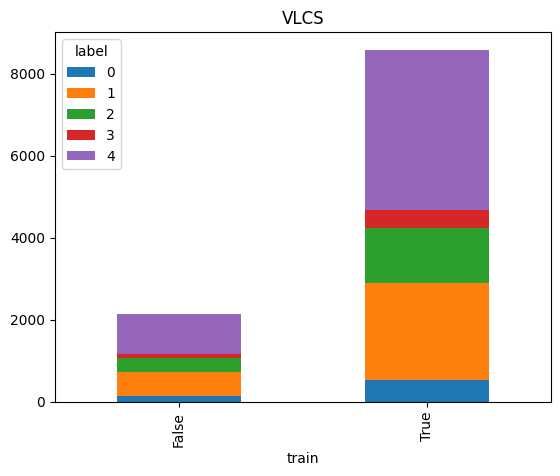

<Figure size 640x480 with 0 Axes>

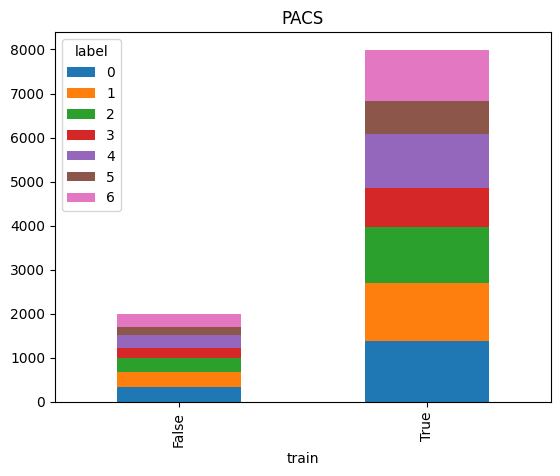

<Figure size 640x480 with 0 Axes>

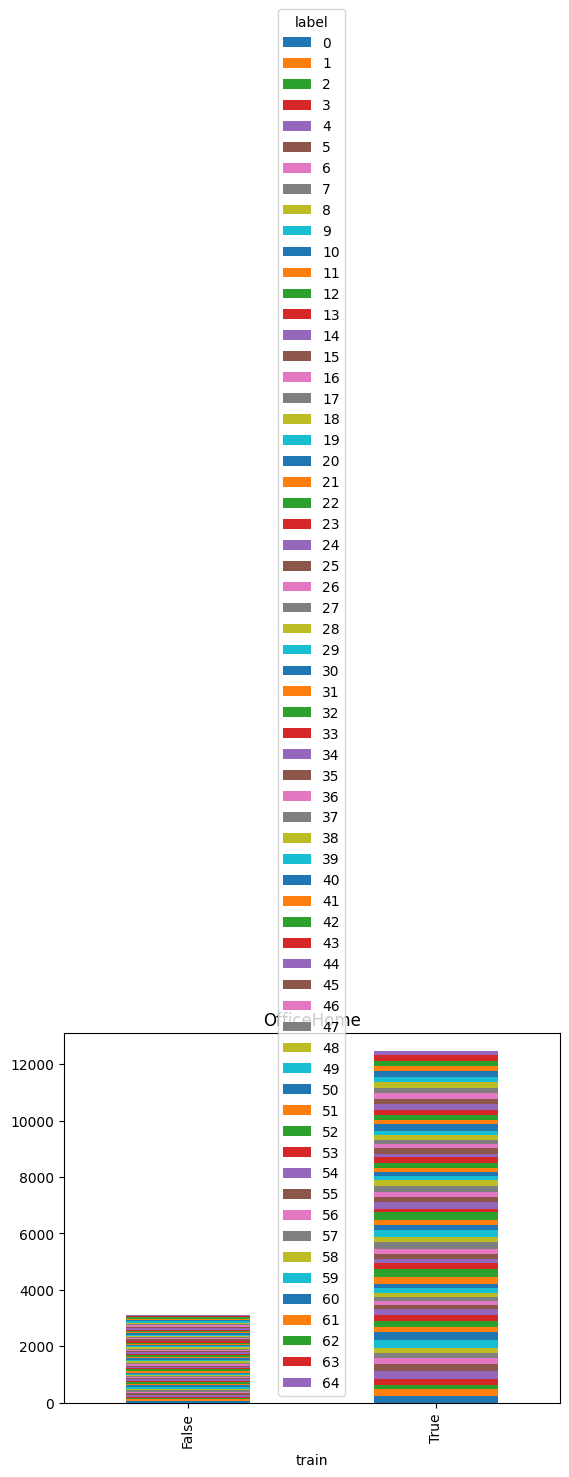

In [20]:
# plot class distribution between train/val
for dataset_name in DATASETS:
    df = pd.read_csv(f"{dataset_name}.csv")
    plt.figure()
    df.groupby("train")["label"].value_counts().unstack().plot(kind="bar", stacked=True)
    plt.title(dataset_name)
    
    # save to file
    plt.savefig(f"report/{dataset_name}_train_val_class_distribution.png", bbox_inches='tight', pad_inches=0.1, dpi=300, transparent=True)
    
    plt.show()



<Figure size 640x480 with 0 Axes>

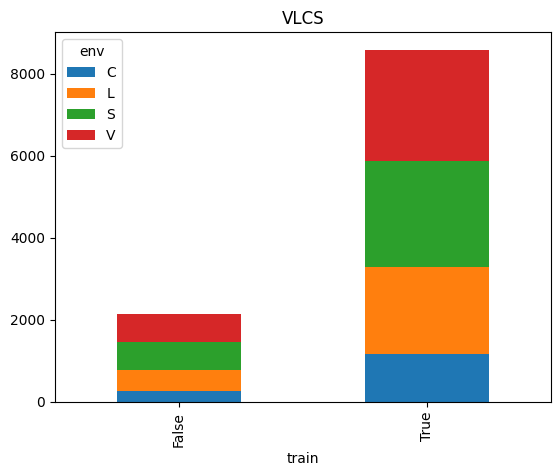

<Figure size 640x480 with 0 Axes>

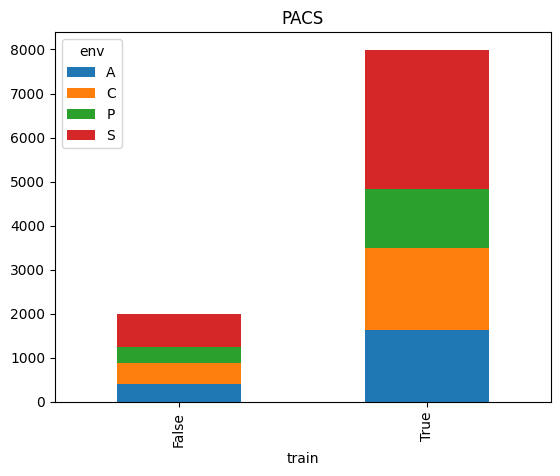

<Figure size 640x480 with 0 Axes>

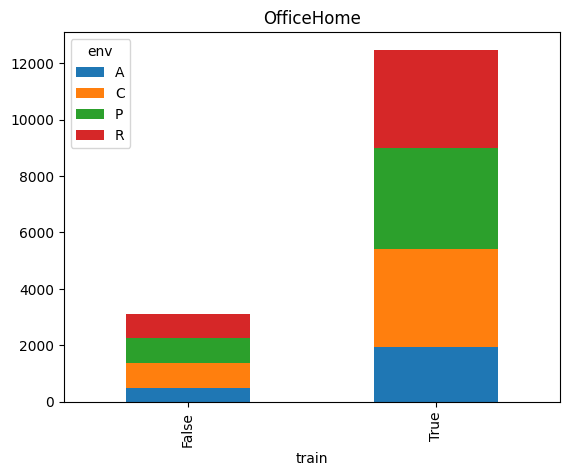

In [21]:
# plot env distribution between train/val
for dataset_name in DATASETS:
    df = pd.read_csv(f"{dataset_name}.csv")
    plt.figure()
    df.groupby("train")["env"].value_counts().unstack().plot(kind="bar", stacked=True)
    plt.title(dataset_name)
    
    # save to file
    plt.savefig(f"report/{dataset_name}_train_val_env_distribution.png", bbox_inches='tight', pad_inches=0.1, dpi=300, transparent=True)